In [2]:
import numpy as np
import numpy.fft as fft
import matplotlib
import matplotlib.pyplot as plt
import math
import random

% matplotlib inline

In [64]:
random.seed(42)
data = np.random.random((128, 128))*65535

In [237]:
def plotImage(img, cmap='gray', vmin=0, vmax=65535):
    fig, ax = plt.subplots()

    params = {'axes.labelsize': 20,'axes.titlesize':20, 'font.size': 20, 'legend.fontsize': 20, 
              'xtick.labelsize': 20, 'ytick.labelsize': 20}
    matplotlib.rcParams.update(params)
    majorLocator = matplotlib.ticker.MultipleLocator(20)
    ax.xaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_locator(majorLocator)
    plt.rcParams["figure.figsize"] = [10, 10]

    fig = plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    
def plotSpectrum(fftData, cmap='gray'):
    fftData2 = np.fft.fftshift(fftData)
    #img = np.arctan(fftData2.imag / (fftData2.real + 10e-20))
    img = freq = np.fft.fftfreq(fftData, n=1)
    #img -= img.min()
    #img /= img.max()
    #img.real += 10e-20
    img = np.log(1 + (img + 10e20))

    img -= img.min()
    img /= img.max()
    plotImage(img, cmap=cmap, vmin=img.min(), vmax=img.max())

Standard distribution equation
$$ Y = (\frac{1}{\sigma \sqrt(2\pi)}) e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$
With $\mu$ the mean and $\sigma$ the standard deviation

FWHM: Full Width at Half Maximum

$$FWHM = 2\sqrt{2 ln(2)} \sigma $$

$$FWHM \simeq 2.355 \sigma $$


In [66]:
# Standard distribution equation
def stdDist(x, mu, sigma):
    '''
    Equation of the standard distribution
    
    Paramaters:
    - x: a number
    - mu: the mean of the function
    - sigma: the standard deviation of the function
    '''
    equation =lambda x, mu, sigma: 1 / (sigma * math.sqrt(2 * math.pi)) * math.exp(-((x - mu)**2) / (2 * sigma**2))
    max = equation(mu, mu, sigma)
    return equation(x, mu, sigma) * (1 / max)

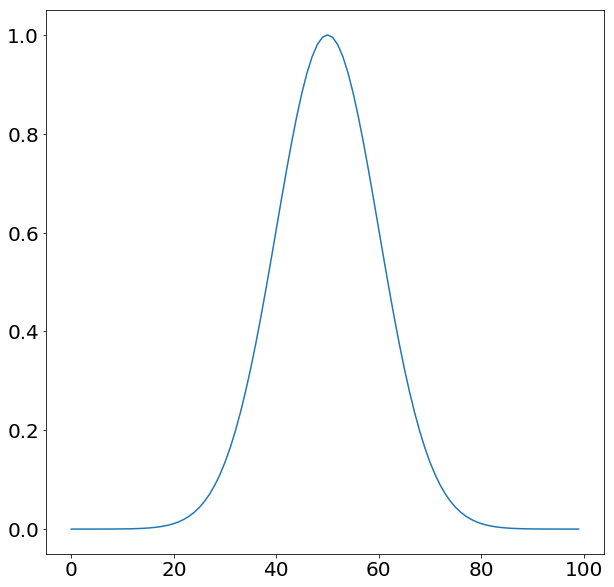

In [67]:
x = np.arange(0, 100., 1)
y = np.array([stdDist(p, 50, 10) for p in x])

plt.plot(x, y)

In [95]:
frame = np.zeros((128,128))

def drawStar(frame, x, y, sigma):
    for horizontal in range(frame.shape[0]):
        for vertical in range(frame.shape[1]):
            frame[horizontal][vertical] += stdDist(horizontal, x, sigma) * stdDist(vertical, y, sigma) * 65535 / (1.7/sigma)

In [96]:
for i in range(50):
    x = random.randint(0, frame.shape[1])
    y = random.randint(0, frame.shape[0])
    sigma = random.randint(3, 10) / 5
    drawStar(frame, x, y, sigma)

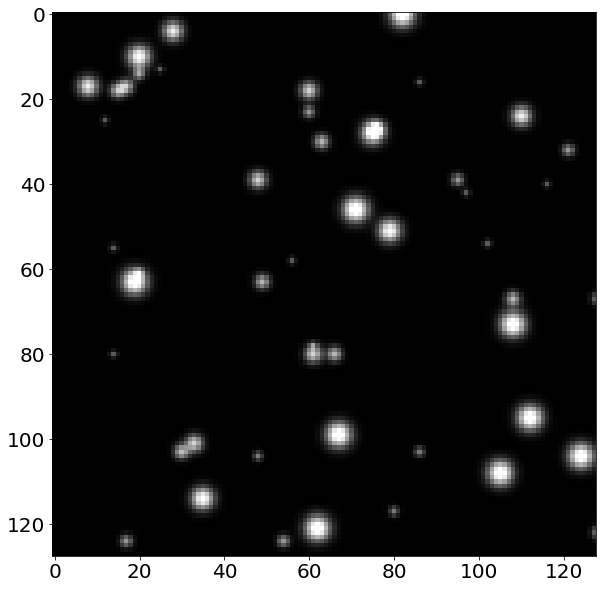

In [140]:
plotImage(frame)

In [98]:
frame.max()

97223.046395204059

In [142]:
completeFrame = frame + data/3

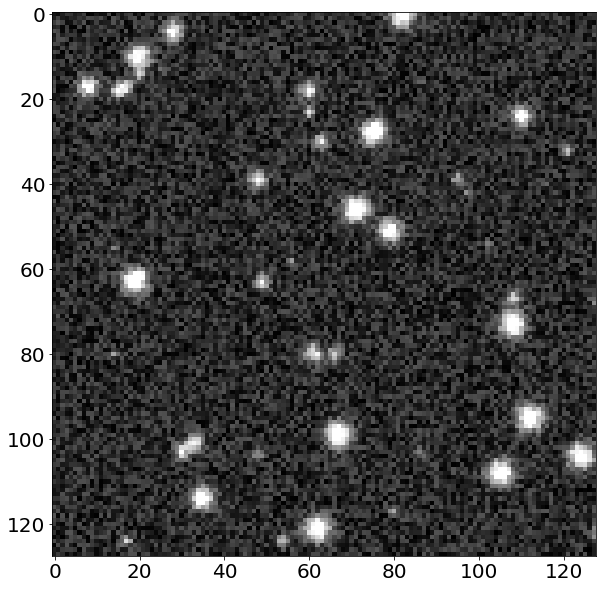

In [143]:
plotImage(completeFrame)

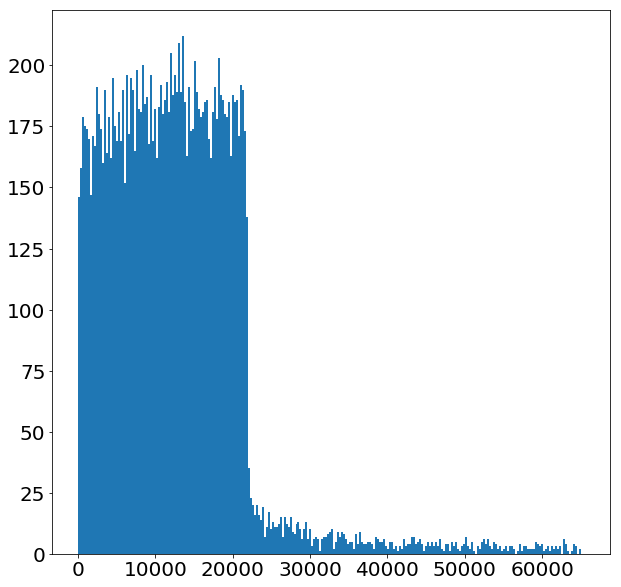

In [101]:

bins  =  np.linspace(0, 65535, 255)
plt.hist(completeFrame.flatten(), bins)
plt.show()

In [145]:
def sigmaClipping(data, sigma=2, iteration=1):     
    shape = data.shape
    res = data
    for i in range(iteration):
        referenceValue = res.mean()
        stdDev = res.std()
        #print(referenceValue - sigma * stdDev)
        #np.putmask(res, res<(referenceValue - sigma * stdDev), referenceValue - sigma * stdDev)
        #np.putmask(res, res>(referenceValue + sigma * stdDev), referenceValue + sigma * stdDev)
        
        res[res<(referenceValue - sigma * stdDev)] = referenceValue - sigma * stdDev
        res[res>(referenceValue + sigma * stdDev)] = referenceValue + sigma * stdDev
        
        #res = [cut(e, referenceValue - sigma * stdDev, referenceValue + sigma * stdDev) for l in res for e in l]
        #res = np.reshape(res, shape)
    return res

In [146]:
clippedImage = sigmaClipping(completeFrame, sigma=1, iteration=4)
#clippedImage -= clippedImage.min()
#clippedImage = (clippedImage / clippedImage.max()) * 65535

In [147]:
completeFrame.mean()

11879.120674045398

In [148]:
completeFrame.std()

3707.151466600747

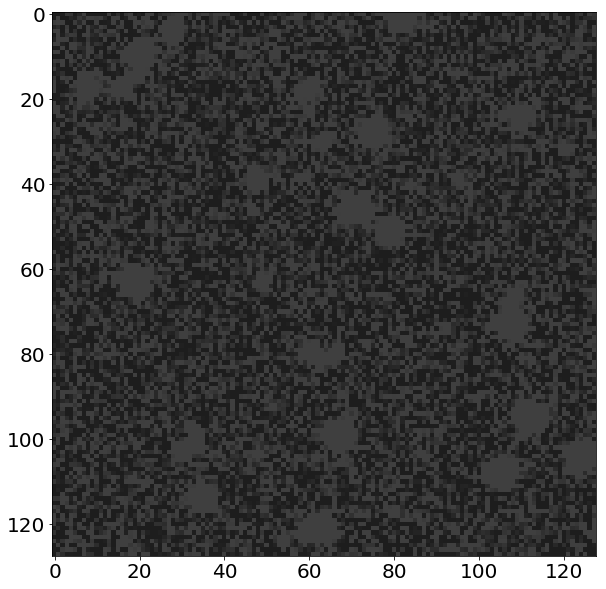

In [150]:
plotImage(clippedImage)

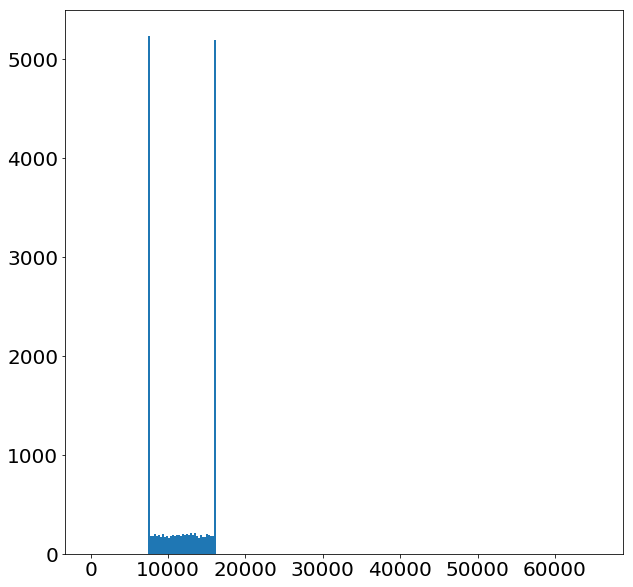

In [151]:
bins  =  np.linspace(0, 65535, 255)
plt.hist(clippedImage.flatten(), bins)
plt.show()

In [166]:
fourierTransform = fft.fft2(completeFrame)
fourierTransform = np.fft.fftshift(fourierTransform)
fourierTransform -= fourierTransform.min()
fourierTransform /= fourierTransform.max()

In [236]:
fourierTransform = fft.fft2(completeFrame)
plotSpectrum(fourierTransform)

ValueError: n should be an integer

In [229]:
fourierTransform.max()

(194627513.1235598+0j)

In [230]:
oneStar = np.zeros((128,128))
drawStar(oneStar, 128/2,128/2,3)

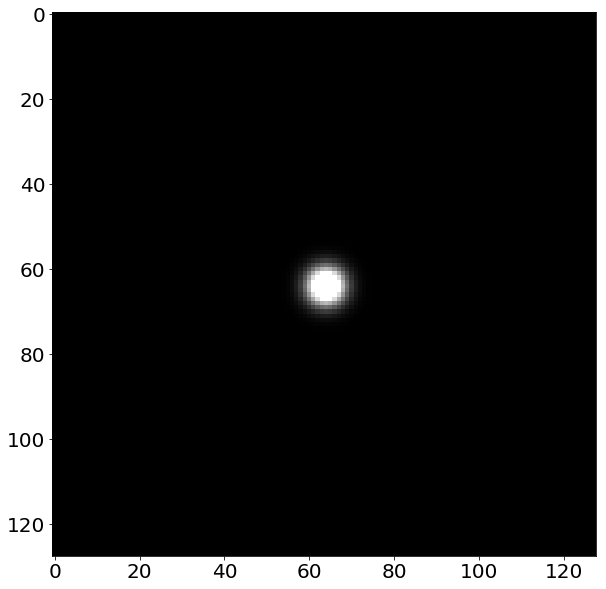

In [231]:
plotImage(oneStar)

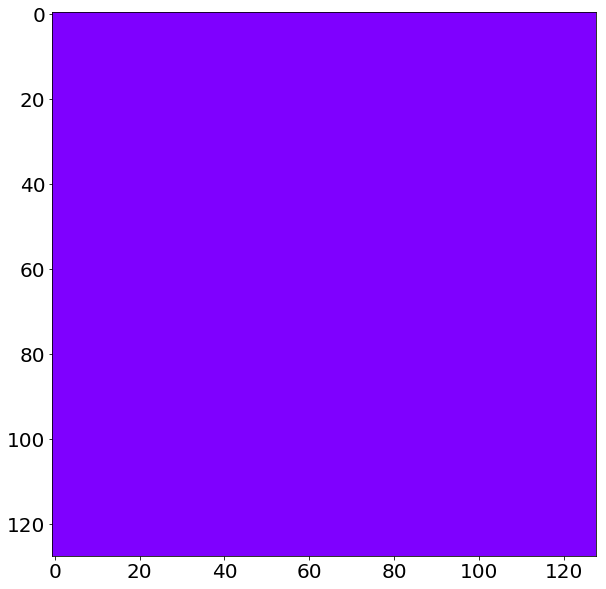

In [232]:
oneStarFFT = fft.fft2(oneStar)
plotSpectrum(oneStarFFT, cmap='rainbow')


In [125]:
oneStarFFT.imag *= -1
result = fourierTransform * oneStarFFT
resultImg = fft.ifft2(result)
resultImg

array([[-12.19182398+0.04908581j, -14.16094514+0.05701374j,
        -14.23347153+0.05730574j, ...,  -3.01446859+0.01213663j,
         -5.82547463+0.02345409j,  -9.11247164+0.03668795j],
       [ -7.07249184+0.02847474j,  -9.61566534+0.03871387j,
        -10.31303408+0.04152157j, ...,   3.58594786-0.01443748j,
          0.37272162-0.00150062j,  -3.43818185+0.01384255j],
       [ -1.19133592+0.00479647j,  -4.18456530+0.01684758j,
         -5.52745814+0.02225424j, ...,   9.87771506-0.03976892j,
          6.69341433-0.02694852j,   2.73387443-0.01100692j],
       ..., 
       [-21.20637757+0.08537953j, -21.09537806+0.08493263j,
        -20.02313856+0.08061566j, ..., -21.62332600+0.08705822j,
        -21.14563172+0.08513496j, -21.03672247+0.08469648j],
       [-19.31534652+0.077766j  , -19.89016241+0.08008028j,
        -19.04302407+0.0766696j , ..., -16.11439472+0.06487857j,
        -16.90369343+0.06805639j, -18.07817156+0.07278498j],
       [-16.29221636+0.0655945j , -17.58826300+0.07081255

In [126]:
#resultImg = resultImg.real**2 + resultImg.imag**2
resultImg = resultImg.real

In [127]:
resultImg -= resultImg.min()
resultImg /= resultImg.max()


In [128]:
resultImg.max()

1.0

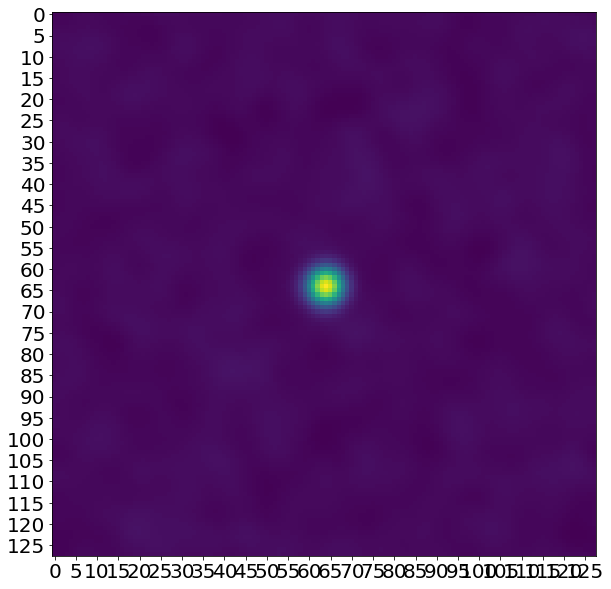

In [129]:
fig, ax = plt.subplots()

params = {'axes.labelsize': 20,'axes.titlesize':20, 'font.size': 20, 'legend.fontsize': 20, 
          'xtick.labelsize': 20, 'ytick.labelsize': 20}
matplotlib.rcParams.update(params)
majorLocator = matplotlib.ticker.MultipleLocator(5)
ax.xaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_locator(majorLocator)
plt.rcParams["figure.figsize"] = [10, 10]

#fig = plt.imshow(fourierTransform.real, cmap='gray', vmin=0, vmax=65000)
fig = plt.imshow(resultImg)

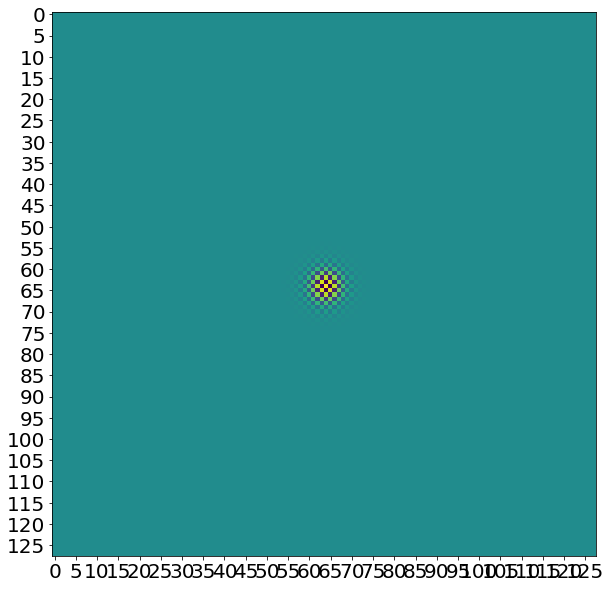

In [135]:
oneStarFFT = np.fft.ifftshift(oneStarFFT)
newOneStar = fft.ifft2(oneStarFFT).real

fig, ax = plt.subplots()

params = {'axes.labelsize': 20,'axes.titlesize':20, 'font.size': 20, 'legend.fontsize': 20, 
          'xtick.labelsize': 20, 'ytick.labelsize': 20}
matplotlib.rcParams.update(params)
majorLocator = matplotlib.ticker.MultipleLocator(5)
ax.xaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_locator(majorLocator)
plt.rcParams["figure.figsize"] = [10, 10]

#fig = plt.imshow(fourierTransform.real, cmap='gray', vmin=0, vmax=65000)
fig = plt.imshow(newOneStar)

In [136]:
newOneStar

array([[  2.47094761e-13,   1.92624954e-13,   1.20349224e-12, ...,
          4.52733275e-13,   2.01443811e-12,  -1.11291372e-12],
       [ -1.18383235e-12,   6.70875397e-13,  -1.78639872e-12, ...,
          7.33066663e-15,  -2.55465322e-12,   1.99576058e-12],
       [  1.83367899e-14,   3.80180345e-13,   7.98975957e-13, ...,
          5.43147501e-13,   1.39828801e-12,  -9.06546884e-13],
       ..., 
       [ -1.26324664e-12,   1.00304225e-12,  -2.16473822e-12, ...,
         -3.83011917e-13,  -1.89227392e-12,   1.81591525e-12],
       [  1.07667282e-12,  -7.50821131e-13,   2.08955950e-12, ...,
          1.14798619e-13,   2.32236312e-12,  -1.78012012e-12],
       [  7.91403587e-13,  -1.16089340e-12,  -4.77376342e-13, ...,
         -6.09009802e-13,  -1.45518761e-12,   2.26563286e-13]])

In [131]:
testArray = np.array([[1,0,0,0,0,1],
                     [0,0,0,0,0,0],
                     [0,0,0,0,0,0],
                     [0,0,0,0,0,0],
                     [0,0,0,0,0,0],
                     [1,0,0,0,0,1]])

In [132]:
testArray2 = np.roll(testArray, 6*6//2)
testArray2 = [np.roll(testArray[i], 3) for i in testArray]

In [133]:
testArray2

[array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0]]), array([[0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0]]), array([[0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0]]), array([[0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0]]), array([[0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0]]), array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 